# **Projeto 1**

- **Fonte:** [Blog da Comunidade DS](https://www.comunidadeds.com/projeto01-blog)
---



# Problema de Negócio

Uma companhia área gostaria de realizar um campanha de marketing para aumentar o número de passageiros que participam do programa de fidelidade da empresa.

O programa de fidelidade da empresa oferece 3 tipos de benefícios, de acordo com o uso e o engajamento do passageiro com a empresa, ao longo do tempo. Esses níveis de prêmios são representados pelos tipos de cartões de fidelidade.

O programa de fidelidade possui 3 cartões de participação: Star, Nova e Aurora. Cada cartão possui níveis de benefícios e prêmios, sendo o Star com menos e o Aurora com mais prêmios.

O time de marketing forneceu uma base de novos clientes para o time comercial entrar em contato e fazer a oferta da assinatura do programa de fidelidade. Porém, não há vendedores suficientes no time comercial para abordar todos os clientes, obrigando o time alcançarem altas taxas de compra da assinatura, para baterem a meta.

Para alcançar a meta o time comercial precisa entrar em contato com o cliente, sabendo qual a probabilidade dele assinar o cartão Star, Nova ou Aurora. Assim, o vendedor consegue oferecer o cartão de maior probabilidade, diminuindo o tempo da venda e aumentando a receita, através da oferta do cartão mais adequado para o perfil de uso de cada cliente.

Você foi contratado como Cientista de Dados para determinar qual a
probabilidade de cada cliente assinar cada um dos 3 cartões do programa de fidelidade. Por exemplo, o cliente A tem  probabilidade de 70% de assinar o cartão Star, 20% de assinar o cartão Nova e 10% de assinar o cartão Aurora.

Como essa informação em mãos, o vendedor pode oferecer para o cliente A, o cartão Star, diretamente.

# 0.0 Imports das bibliotecas

In [1]:
# abrindo a conexao com banco de dados
import sqlite3
import pandas as pd
import numpy as np
import gradio as gr
import pickle

from sklearn import tree as tr

c:\Users\garri\anaconda3\envs\projeto01\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1.0 Coletando de Dados

In [4]:
conn = sqlite3.connect( "../datasets/db_raw/database.db")

In [ ]:
# Recuperando o nome de todas as tabelas presentes no banco de dados "database.db"
tabelas = conn.execute("SELECT NAME FROM sqlite_master WHERE TYPE = 'table' ORDER BY NAME").fetchall()
for tabela in tabelas:
    print(tabela)

('flight_activity',)
('flight_loyalty_history',)


## 1.1 Consultas Globais

In [5]:
consulta_completa = """
SELECT *
FROM flight_activity fa
LEFT JOIN flight_loyalty_history flh ON (fa.loyalty_number = flh.loyalty_number)

"""

df_completo = pd.read_sql_query(consulta_completa, conn)

In [ ]:
# consulta dos dados no banco de dados
consulta_voos = """
SELECT
    fa.loyalty_number,
    fa.year AS ano,
    fa.month AS mes,
    fa.flights_booked AS voos_reservados
FROM flight_activity fa
WHERE
    fa.flights_booked > 3

"""
df_voos = pd.read_sql_query( consulta_voos, conn )

In [ ]:
df_voos.head()

,loyalty_number,ano,mes,voos_reservados
0,100102,2017,1,10
1,100140,2017,1,6
2,100428,2017,1,6
3,863070,2017,9,8
4,100727,2017,1,11


# 2.0 Analise de Dados e Primeiros Insights

In [9]:
# Coletando os dados do ggogle drive
original_url = 'https://drive.google.com/file/d/1n3Zt2V4M4O6C1ASBUuZlVZdpKLZOEpSi/view?usp=sharing'
file_id = original_url.split('/')[-2]
download_url = 'https://drive.google.com/uc?id=' + file_id 
dados_completos = pd.read_pickle(download_url)
dados_completos.head()


,loyalty_number,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed,...,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month
0,100018,2017,1,3,0,3,1521,152.0,0,0,...,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,NaN,NaN
1,100102,2017,1,10,4,14,2030,203.0,0,0,...,College,NaN,Single,Nova,2887.74,Standard,2013,3,NaN,NaN
2,100140,2017,1,6,0,6,1200,120.0,0,0,...,College,NaN,Divorced,Nova,2838.07,Standard,2016,7,NaN,NaN
3,100214,2017,1,0,0,0,0,0.0,0,0,...,Bachelor,63253.0,Married,Star,4170.57,Standard,2015,8,NaN,NaN
4,100272,2017,1,0,0,0,0,0.0,0,0,...,Bachelor,91163.0,Divorced,Star,6622.05,Standard,2014,1,NaN,NaN


## 2.1 Inspecionando Dados

In [ ]:
# Verifica o número de linhas de um dataframe
print(f'Quantidade de linhas: {df_completo.shape[0]:,.2f} e colunas {df_completo.shape[1]} do dataframe')

Quantidade de linhas: 405,624.00 e colunas 26 do dataframe


In [ ]:
# Insights iniciais
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loyalty_number               405624 non-null  int64  
 1   year                         405624 non-null  int64  
 2   month                        405624 non-null  int64  
 3   flights_booked               405624 non-null  int64  
 4   flights_with_companions      405624 non-null  int64  
 5   total_flights                405624 non-null  int64  
 6   distance                     405624 non-null  int64  
 7   points_accumulated           405624 non-null  float64
 8   points_redeemed              405624 non-null  int64  
 9   dollar_cost_points_redeemed  405624 non-null  int64  
 10  loyalty_number               405624 non-null  int64  
 11  country                      405624 non-null  object 
 12  province                     405624 non-null  object 
 13 

In [ ]:
menor_distancia = df_completo.loc[:, 'distance'].min()
maior_distancia = df_completo.loc[:, 'distance'].max()
media_distancia = df_completo.loc[:, 'distance'].mean()
soma_distancia = df_completo.loc[:, 'distance'].sum()

In [ ]:
df_completo.isna().sum()

loyalty_number                      0
year                                0
month                               0
flights_booked                      0
flights_with_companions             0
total_flights                       0
distance                            0
points_accumulated                  0
points_redeemed                     0
dollar_cost_points_redeemed         0
loyalty_number                      0
country                             0
province                            0
city                                0
postal_code                         0
gender                              0
education                           0
salary                         102672
marital_status                      0
loyalty_card                        0
clv                                 0
enrollment_type                     0
enrollment_year                     0
enrollment_month                    0
cancellation_year              355560
cancellation_month             355560
dtype: int64

In [ ]:
# fecha a conexão com o banco de dados
conn.close()

## 2.2 Preparação dos Dados

In [4]:
df_limpo = df_completo.copy()

In [5]:
# Número de dados faltantes em cada coluna
df_limpo.isna().sum()

# Selecionar somente as colunas que contem erros
colunas = ['year', 'month', 'flights_booked', 'flights_with_companions', 'total_flights',
                    'distance', 'points_accumulated', 'salary', 'clv', 'loyalty_card']

df_colunas_numericas = df_limpo.loc[:, colunas]

# Remover linhas que contem dados faltante
df_treinamento = df_colunas_numericas.dropna()

# Verificar se existe dados faltantes
df_treinamento.isna().sum()

year                       0
month                      0
flights_booked             0
flights_with_companions    0
total_flights              0
distance                   0
points_accumulated         0
salary                     0
clv                        0
loyalty_card               0
dtype: int64

In [ ]:
df_treinamento.shape

(302952, 10)

# 3.0 Treinamento do Algoritmo de Machine Learning

In [6]:
X_atributos = df_treinamento.drop(columns='loyalty_card')
y_rotulos = df_treinamento.loc[:, 'loyalty_card']

# Definição do algortimo
modelo = tr.DecisionTreeClassifier(max_depth=5)

# Treinamento do algoritmo
modelo_treinado = modelo.fit(X_atributos, y_rotulos)

In [8]:
import pickle
pickle.dump(modelo_treinado, open('../datasets/modelo/modelo_treinando.pkl', 'wb'))

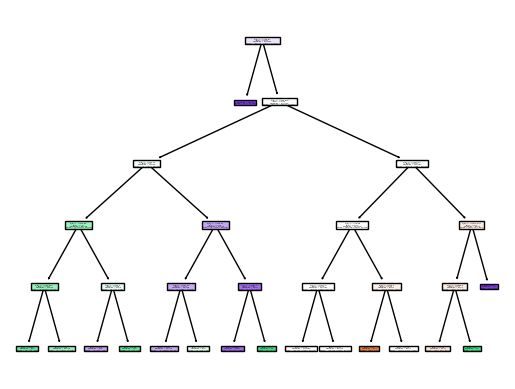

In [ ]:
tr.plot_tree(modelo_treinado, filled=True);

# 4.0 Apresentando resultado

In [8]:
X_novo = X_atributos.sample()
previsao = modelo_treinado.predict_proba(X_novo)

print(f'Prob - Aurora: { 100 * previsao[0][0]:.2f}% - Nova: { 100 * previsao[0][1]:.2f}% - Start: { 100 * previsao[0][2]:.2f}%')


Prob - Aurora: 33.93% - Nova: 33.35% - Start: 32.72%


# 5.0 Painel Web

In [10]:
def predict(*args):
    X = np.array([args]).reshape(1,-1)
    y_pred = modelo_treinado.predict_proba(X)

    return {"Aurora": y_pred[0][0], "Nova": y_pred[0][1], "Start": y_pred[0][2]}

# theme = 'upsatwal/mlsc_tiet'
with gr.Blocks() as demo:

    # Titulo do painel
    gr.Markdown( """# Propensão de Compra""")

    with gr.Row():
        # Coluna 1
        with gr.Column():
            gr.Markdown(""" # Atributos do Cliente """)
            year 		            = gr.Slider(label="year", minimum=2017, maximum=2018,step=1, randomize=True)
            month                   = gr.Slider(label="month", minimum=1, maximum=12,step=1, randomize=True)
            flights_booked          = gr.Slider(label="flights_booked",minimum=0, maximum=21, step=1, randomize=True)
            flights_with_companions = gr.Slider(label="flights_with_companions", minimum=0,maximum=11, step=1, randomize=True)
            total_flights           = gr.Slider(label="total_flights", minimum=0, maximum=32,step=1, randomize=True)
            distance                = gr.Slider(label="distance", minimum=0, maximum=6293, step=1, randomize=True)
            points_accumulated      = gr.Slider(label="points_accumulated", minimum=0.00, maximum=676.50, step=0.1, randomize=True)
            salary                  = gr.Slider(label="salary", minimum=58486.00, maximum=407228.00, step=0.1, randomize=True)
            clv                     = gr.Slider(label="clv", minimum=2119.89, maximum=83325.38, step=0.1, randomize=True)

            with gr.Row():
                predict_btn = gr.Button(value="Previsão")

        # Coluna 2
        with gr.Column():
            gr.Markdown("""# Propensão de Compra do Cliente""")
            label = gr.Label()

        # Botao de Predict
        predict_btn.click(
                fn=predict,
                inputs=[
                year,
                month,
                flights_booked,
                flights_with_companions,
                total_flights,
                distance,
                points_accumulated,
                salary,
                clv
                ],
                outputs=[label] )

demo.launch(debug=True, share=False)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
